In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [2]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [3]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from segmentation_models_pytorch import utils

In [4]:
DATA_DIR = '/Users/ananyashukla/Desktop/Ananya_Shukla/Semester 4/MLPR/SIIM-ACR Pneumothorax Segmentation/code_dir/Dataset/'
print(os.getcwd())
print(os.listdir(DATA_DIR))

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    # os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

/Users/ananyashukla/Downloads
['png_files', 'mask_files_stage2', '.DS_Store', 'mask_files', 'stage_2_train.csv', '.gitignore', 'metadata.csv', 'train-rle.csv', '.git', 'png_files_stage2', 'metadata_stage2.csv']


In [5]:
x_train_dir = os.path.join(DATA_DIR, 'png_files')
y_train_dir = os.path.join(DATA_DIR, 'mask_files')
pn_train = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
df_train_pn = pn_train[pn_train['Pneumothorax'] == 1]
df_train_pn=df_train_pn['DICOM'].to_list()

x_valid_dir = os.path.join(DATA_DIR, 'png_files_stage2')
y_valid_dir = os.path.join(DATA_DIR, 'mask_files_stage2')
pn_val = pd.read_csv(os.path.join(DATA_DIR, 'metadata_stage2.csv'))
df_val_pn = pn_val[pn_val['Pneumothorax'] == 1]
df_val_pn=df_val_pn['DICOM'].to_list()

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #            'tree', 'signsymbol', 'fence', 'car', 
    #            'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            pn_df,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            # train = True
    ):
        # self.ids = [f for f in pn_df if not f.startswith('.')]
        self.ids = pn_df
        self.images_fps = [os.path.join(images_dir, image_id+".png") for image_id in self.ids if not image_id.startswith('.')]
        self.masks_fps = [os.path.join(masks_dir, image_id+"_mask.png") for image_id in self.ids if not image_id.startswith('.')]
        # print(self.images_fps)
        # self.masks_fps = [os.path.join(masks_dir, ".".join(image_id.split(".")[:-1])+"_mask.png") for image_id in self.ids if not image_id.startswith('.')]
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        # print(self.images_fps[i])
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in [255]]
        masks = [(mask == 255)]
        # masks = mask == 255
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

(1024, 1024, 3)
(1024, 1024, 1)
{0.0, 1.0}


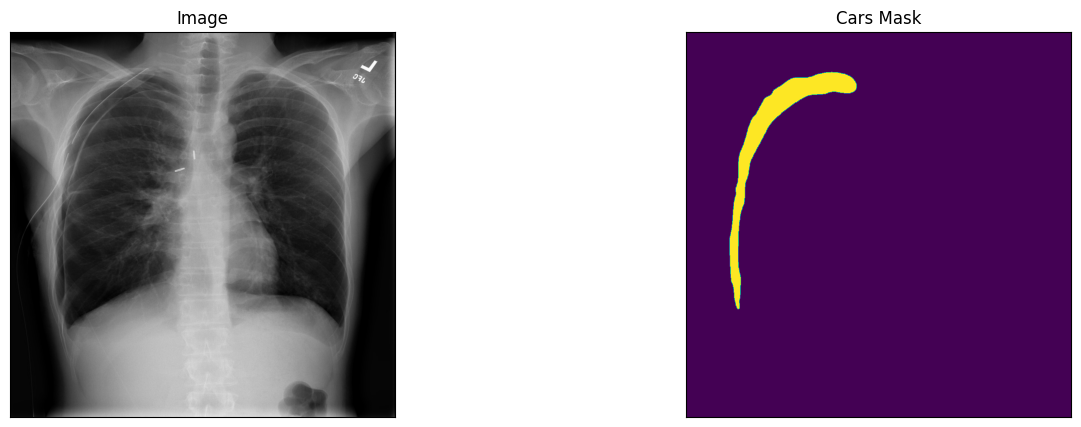

In [9]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, pn_df=df_train_pn)

image, mask = dataset[2] # get some sample
print(image.shape)
print(mask.shape)
print(set(mask.flatten()))
np.savetxt('mask.txt',mask.squeeze(), fmt='%d')
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [10]:
import albumentations as albu

In [11]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=370, min_width=370, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        # albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [12]:
#### Visualize resulted augmented images and masks

# augmented_dataset = Dataset(
#     x_train_dir, 
#     y_train_dir, 
#     augmentation=get_training_augmentation(), 
#     classes=['car'],
# )

# # same image with different random transforms
# for i in range(3):
#     image, mask = augmented_dataset[1]
#     visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [14]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'mps'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    # classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [15]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    pn_df=df_train_pn,
    # augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    # classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    pn_df=df_val_pn,
    # augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    # classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [16]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [17]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [18]:
# train model for 40 epochs

max_score = 0

for i in range(0, 30):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 290/290 [00:49<00:00,  5.88it/s, dice_loss - 0.9446, iou_score - 0.05696]
Model saved!

Epoch: 1
valid: 100%|██████████| 290/290 [00:50<00:00,  5.72it/s, dice_loss - 0.9227, iou_score - 0.1291]
Model saved!

Epoch: 2
valid: 100%|██████████| 290/290 [00:47<00:00,  6.07it/s, dice_loss - 0.6322, iou_score - 0.2578]
Model saved!

Epoch: 3
valid: 100%|██████████| 290/290 [00:47<00:00,  6.12it/s, dice_loss - 0.6385, iou_score - 0.2764] 
Model saved!

Epoch: 4
valid: 100%|██████████| 290/290 [00:47<00:00,  6.12it/s, dice_loss - 0.5169, iou_score - 0.3725]
Model saved!

Epoch: 5
valid: 100%|██████████| 290/290 [00:47<00:00,  6.13it/s, dice_loss - 0.5448, iou_score - 0.3568]

Epoch: 6
valid: 100%|██████████| 290/290 [00:47<00:00,  6.14it/s, dice_loss - 0.5286, iou_score - 0.3658]

Epoch: 7
valid: 100%|██████████| 290/290 [00:49<00:00,  5.82it/s, dice_loss - 0.5835, iou_score - 0.3284]

Epoch: 8
valid: 100%|██████████| 290/290 [00:47<00:00,  6.08it/s, dice_loss 

## Test best saved model

In [24]:
for i in range(30, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    else:
        torch.save(model,f'./model_epoch{i}.pth')
        print('Non-Best Model saved!')


Epoch: 30
valid: 100%|██████████| 290/290 [00:47<00:00,  6.08it/s, dice_loss - 0.5834, iou_score - 0.3298]
Non-Best Model saved!

Epoch: 31
valid: 100%|██████████| 290/290 [00:47<00:00,  6.08it/s, dice_loss - 0.5874, iou_score - 0.3258]
Non-Best Model saved!

Epoch: 32
valid: 100%|██████████| 290/290 [00:47<00:00,  6.06it/s, dice_loss - 0.6016, iou_score - 0.3148]
Non-Best Model saved!

Epoch: 33
valid: 100%|██████████| 290/290 [00:47<00:00,  6.07it/s, dice_loss - 0.5913, iou_score - 0.3229]
Non-Best Model saved!

Epoch: 34
valid: 100%|██████████| 290/290 [00:47<00:00,  6.06it/s, dice_loss - 0.577, iou_score - 0.3338] 
Non-Best Model saved!

Epoch: 35
valid: 100%|██████████| 290/290 [00:47<00:00,  6.09it/s, dice_loss - 0.5756, iou_score - 0.3345]
Non-Best Model saved!

Epoch: 36
valid: 100%|██████████| 290/290 [00:48<00:00,  6.00it/s, dice_loss - 0.5749, iou_score - 0.3344]
Non-Best Model saved!

Epoch: 37
valid: 100%|██████████| 290/290 [00:49<00:00,  5.90it/s, dice_loss - 0.5852, io

In [35]:
# load best saved checkpoint
torch.save(model, './last_model.pth')
# best_model = torch.load('./best_model.pth')
best_model = torch.load('./last_model.pth')

In [36]:
# create test dataset
test_dataset = Dataset(
    # x_test_dir, 
    # y_test_dir, 
    x_valid_dir,
    y_valid_dir,
    pn_df=df_val_pn,
    # augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [37]:
# evaluate model on test set
test_epoch = utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 290/290 [00:49<00:00,  5.90it/s, dice_loss - 0.6026, iou_score - 0.3131]


## Visualize predictions

In [38]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    # x_test_dir, y_test_dir, 
    # x_valid_dir, y_valid_dir, pn_df=df_val_pn,
    x_train_dir, y_train_dir, pn_df=df_train_pn,
    # classes=CLASSES,
)

{0.0, 1.0}


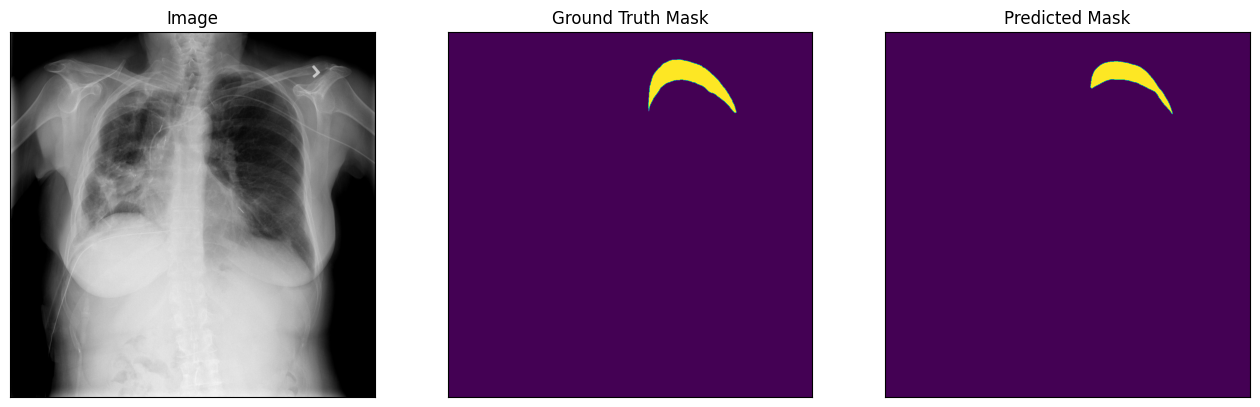

{0.0, 1.0}


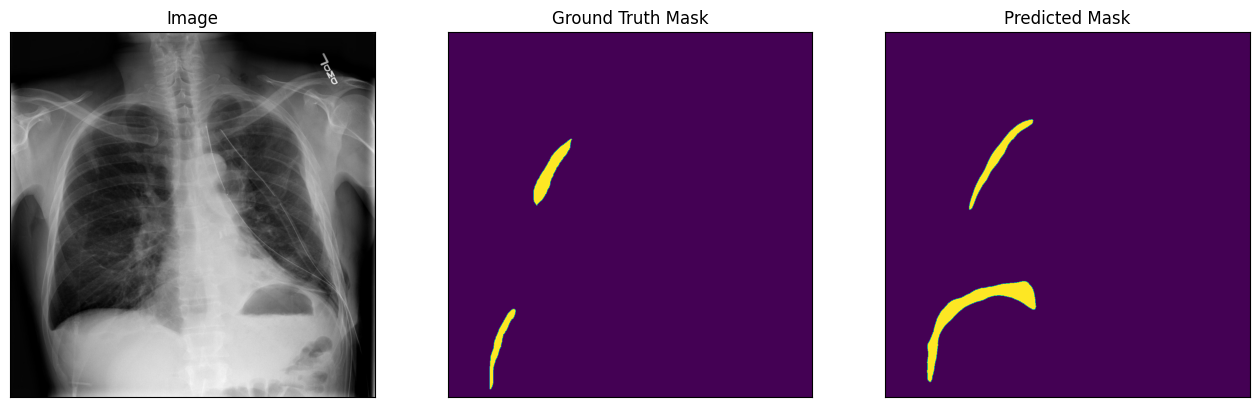

{0.0, 1.0}


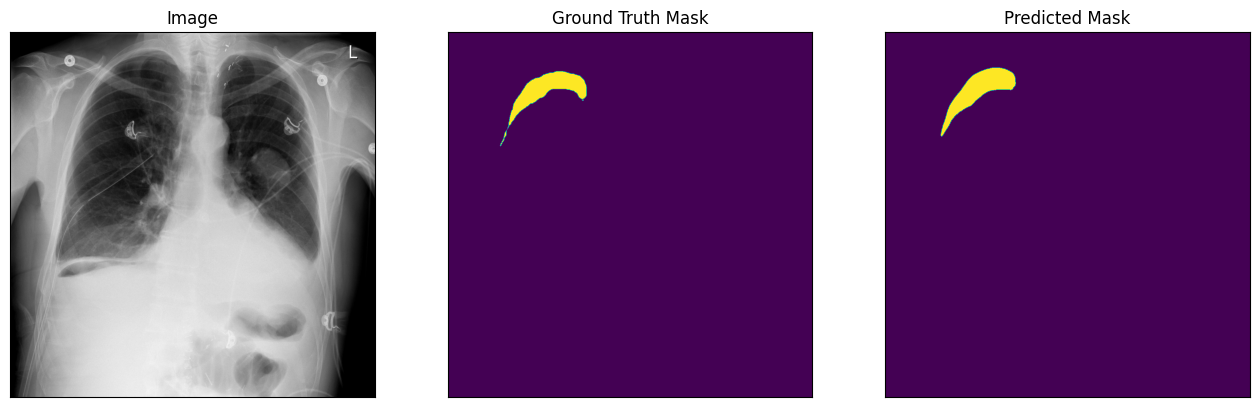

{0.0, 1.0}


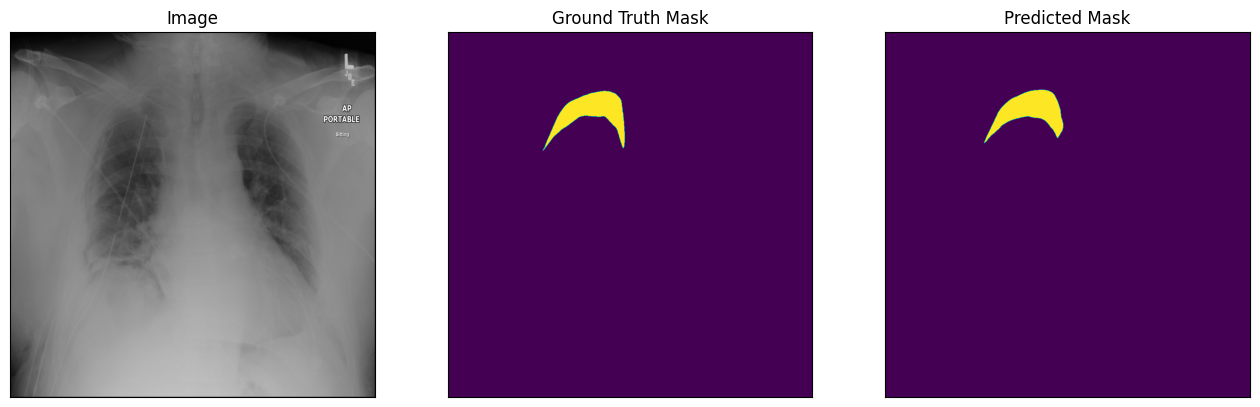

{0.0, 1.0}


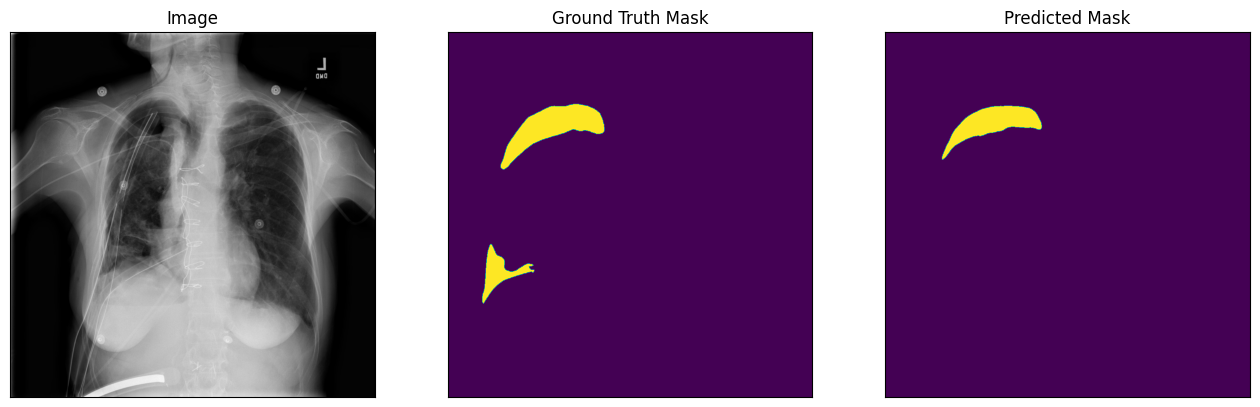

In [39]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8') # check this line on his thingie too
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    print(set(pr_mask.flatten()))
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )